# Simultaneous N-Gaussian Fitting

Author : Melih Kara <br>
Created : 16/05/2021

This is a exploratory analysis practice. I use several experimental data from a bachelor physics lab which requires multiple gaussians to be fitted simultaneously. <br>
I write a simple gaussian, define a loss function, define a parameter optimization and optimize parameters for arbitrarily many gaussians. In addition to that, I'll try to estimate _initial guesses_ 

In [3]:
# following scripts sets a couple of parameters
# does the basics imports and adjust matplotlib params
%run set_params.py
import scipy.signal
from scipy import optimize
import scipy.stats as stats
from glob import glob

In [4]:
data55 = np.loadtxt('./data/mitMFCCD_I=5.5BZ6.txt',encoding='latin1')
data65 = np.loadtxt('./data/mitMFCCD_I=6.5BZ6.txt',encoding='latin1')
data70 = np.loadtxt('./data/mitMFCCD_I=7.0BZ7.txt',encoding='latin1')
data80 = np.loadtxt('./data/mitMFCCD_I=8.0BZ6.txt',encoding='latin1')
data90 = np.loadtxt('./data/mitMFCCD_I=9.0BZ7.txt',encoding='latin1')

Below is the data, and the region we are interested in. Out aim is to fit 3 gaussians in the first main peak, which physically corresponds to Zeeman splitting.

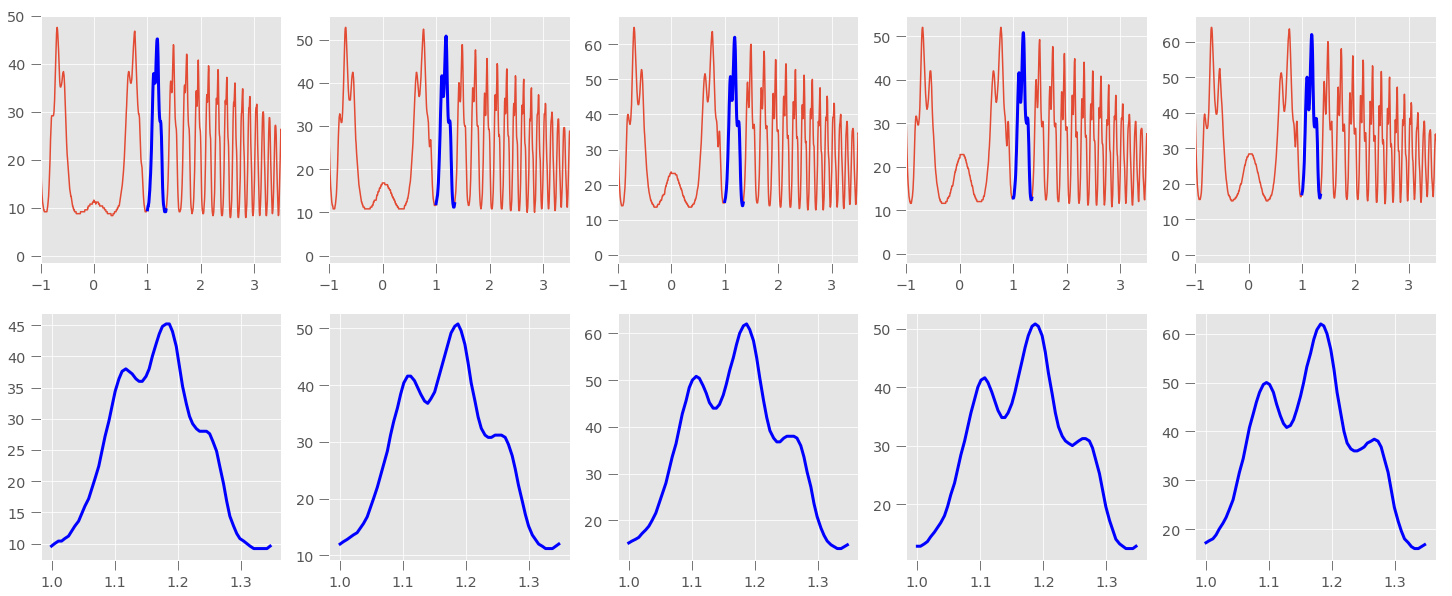

In [5]:
fig, ((axes_r1), axes_r2) = plt.subplots(ncols=5, nrows=2, figsize=(25,10))
for ax1,ax2, data in zip(axes_r1, axes_r2,\
                   [data55,data65,data70,data80,data90]):
    x_ = data[:,0]
    y_ = data[:,1]
    ax1.plot(x_,y_)
    xmask = (x_<=1.35) & (x_>=1.0)
    x = x_[xmask]
    y = y_[xmask]
    ax1.plot(x,y, color='b', lw=3)
    ax1.set_xlim(-1.0,3.5)
    ax2.plot(x,y, color='b', lw=3)

In [6]:
def make_guess(data, Npks, Dx=None, verbose=True):
    """
    Returns guesses for Npks number of peaks
    as center - amplitude - width
    eg [x_0, y_0, width_0, ... ,
        x_N, y_N, width_N]
    """
    # the data is scrambled, so I first sort x and y values
    
    x = data[:,0]      #  x vals
    y = data[:,1]      #  y vals 

    # NOTE: initial inspection is usefull to select initial widths
    # I want DX to be around 2 so that peaks can be discriminated
    DX = Dx or (np.max(x)-np.min(x))/float(Npks) # starting guess for component width
    dxs = np.repeat(DX, Npks)
    
    # Find peaks in a 1-D array with wavelet transformation
    i_pk = scipy.signal.find_peaks_cwt(y, widths=[1])
    if len(i_pk)>Npks:
        yvals = np.unique(y[i_pk])
        y_maxNpks = np.sort(yvals)[::-1][:Npks]
        y_maxNpks_idx = np.in1d(yvals, y_maxNpks).nonzero()

        xs = x[i_pk][y_maxNpks_idx]
        ys = y[i_pk][y_maxNpks_idx]
        guess = np.column_stack((xs,ys, dxs))
    elif len(i_pk)<Npks:
        return print('hops')
    else: guess = np.column_stack((x[i_pk],y[i_pk], dxs))
    guess = np.ravel(guess)
    if verbose:
        for i in range(0, len(guess), 3):
            print(f'Peak {int(i/3)}\t\t cent:{guess[i]:.2f}, amp:{guess[i+1]:.2f}, width:{guess[i+2]:.2f}\n')
    return guess

$$Gauss(\mu,\sigma)=A\times\exp\left(-\frac{-(x-x_{\text{cent}})^2}{2\sigma^2}\right)+\text{offset}$$

In [7]:
def gaussian(x, center, height, width, offset=0):
    '''
    Simple 1D gaussian function
    '''
    return height*np.exp(-(x - center)**2/(2*width**2)) + offset

Below, we compute a sum of arbitrary number of Gaussians determined by the number of given initial parameters.

In [8]:
def N_gaussians(x, params):
    '''
    Arguments
    ---------
    x     : array-like
       x-values to put gaussians
    params: array-like
       N*3 initial guesses for gaussians
       the ordering has to be center - amp - width
    Returns
    -------
    y  :  array-like
       The sum of all gaussians
    '''
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        ctr = params[i]
        amp = params[i+1]
        wid = params[i+2]
        y = y + gaussian(x, ctr, amp, wid)
    return y

First, lets take a look at `data55`

In [9]:
data_filt = data55[(data55[:,0]<=1.35)&(data55[:,0]>1.0)]
x = data_filt[:,0]
y = data_filt[:,1]

Below, we define an *error function* which is simply a square error i.e. the square of the difference between the expected gaussian for a given set of parameters to the actual data points. <br>
Next, we optimize this selection of given parameters using a least square optimization. This function starts with initial set of guesses and tries the parameters and computes the error function, then depending on the success it varies the parameters and tries other parameters until it converges and the set of parameters that give the least square error is chosen to be the optimal parameters.

In [10]:
# make initial guesses
guesses = make_guess(data_filt, 4, Dx=0.05, verbose=True)

Peak 0		 cent:1.34, amp:9.20, width:0.05

Peak 1		 cent:1.25, amp:27.60, width:0.05

Peak 2		 cent:1.19, amp:45.20, width:0.05

Peak 3		 cent:1.11, amp:36.40, width:0.05



In [11]:
errfunc = lambda p, x_, y_: (N_gaussians(x_, p) - y_)**2
optim, success = optimize.leastsq(errfunc, guesses[:], args=(x, y))

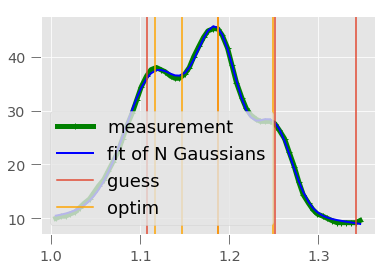

In [12]:
plt.plot(x, y, lw=5, c='g', marker='+', label='measurement')
xl,yl = plt.xlim(), plt.ylim()
# get y values with your best fit parameters
y_fitted = N_gaussians(x, optim)
plt.plot(x, y_fitted, lw=2, c='b', label='fit of N Gaussians')

for i in range(0, len(guesses), 3):
    l1,l2=None,None
    if i == 0: l1='guess'; l2 = 'optim'
    plt.axvline(guesses[i], label=l1)
    plt.axvline(optim[i], color='orange', label=l2)
plt.legend();

As can be seen, data is well fitted with 4 gaussians. Below, I write a function to do these steps automatically

In [13]:
def do_multiple_fit(data, name='', Npeaks=4, llim=1.0, ulim=1.35,\
                    dx=None, guesses=None, show_indiv=True):
    data_filt = data[(data[:,0]<=ulim)&(data[:,0]>llim)]
    x = data_filt[:,0]
    y = data_filt[:,1]
    guesses = guesses or make_guess(data_filt, Npeaks, Dx=0.05, verbose=False)
    
    errfunc = lambda p, x_, y_: (N_gaussians(x_, p) - y_)**2
    optim, success = optimize.leastsq(errfunc, guesses[:], args=(x, y))
    
    fig = plt.figure(figsize=(10,7))
    plt.plot(x, y, lw=5, color='g', marker='+', alpha=0.5, label='measurement')
    plt.plot(x, N_gaussians(x, optim),
        lw=3, c='b', label=f'fit of {int(len(optim)//3)} Gaussians')
    
    print(stats.chisquare(f_obs=y, f_exp=N_gaussians(x,optim)))
    yl,yu = plt.ylim()
    xl,xu = plt.xlim()
    ypos = (yu-yl)*0.1
    for i in range(0, len(guesses), 3):
        l1,l2=None,None
        if i == 0: l1='init guess'; l2 = 'optimal'
        plt.axvline(guesses[i], label=l1, alpha=0.3, lw=2)
        plt.axvline(optim[i], color='cyan', label=l2, alpha=0.3, lw=2)
        ctr = optim[i]
        amp = optim[i+1]
        wid = optim[i+2]
        if show_indiv:
            yt = gaussian(x, ctr, amp, wid)
            plt.plot(x[yt>0.1], yt[yt>0.1], ls='--', color='pink')
            # peak y points
            plt.hlines(amp, ctr-0.01, ctr+0.01, color='k')
            plt.text(ctr-.01, amp+0.05, f'{amp:.3f}', clip_on=True)
            # peak x points 
            plt.text(ctr-.01, yl+ypos, f'{ctr:.2f}', rotation='vertical', fontsize=13, clip_on=True)   

    plt.grid(False)
    plt.xlim(xl,xu)
    plt.legend(fontsize=15)
    plt.title('Data_ '+ name)
    plt.show()
    return optim

Power_divergenceResult(statistic=0.454597328842186, pvalue=1.0)


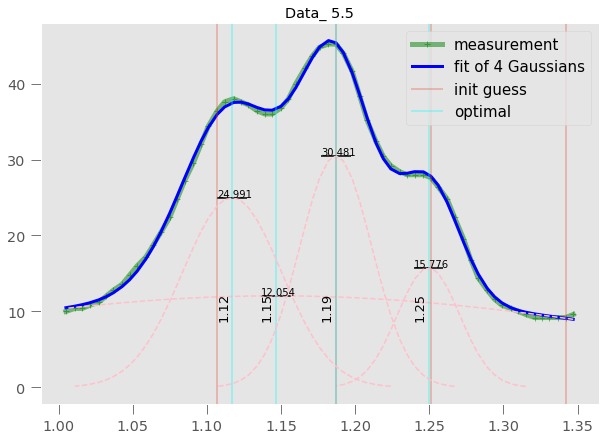

In [14]:
o = do_multiple_fit(data55, guesses=None, dx=0.08, name='5.5')

Power_divergenceResult(statistic=0.454597328842186, pvalue=1.0)


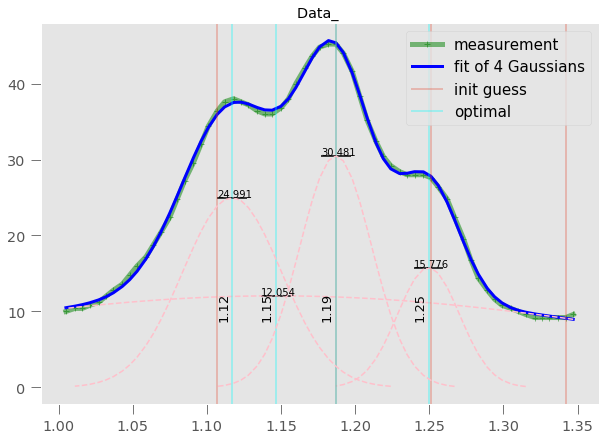

Power_divergenceResult(statistic=8.179841564568473, pvalue=1.0)


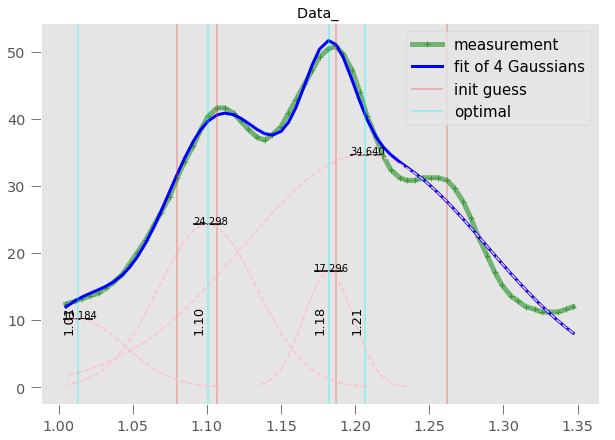

Power_divergenceResult(statistic=0.5863836039444492, pvalue=1.0)


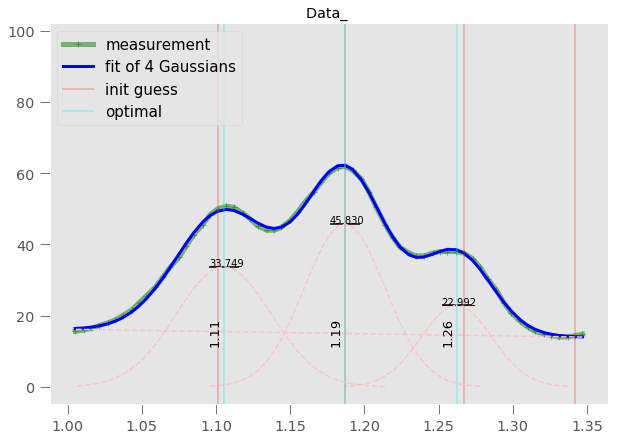

Power_divergenceResult(statistic=6.99086351535338, pvalue=1.0)


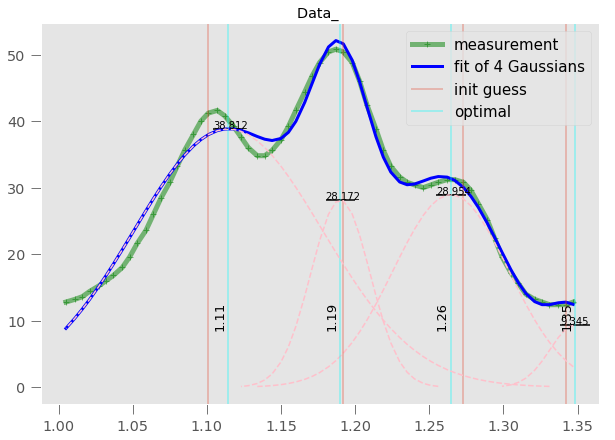

Power_divergenceResult(statistic=6.03541274997661, pvalue=1.0)


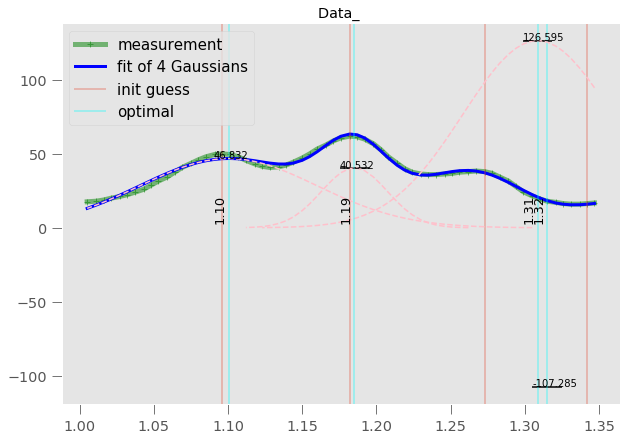

In [15]:
for data in [data55,data65,data70,data80,data90]:
    do_multiple_fit(data, guesses=None, dx=0.08, name='', show_indiv=True)

Even with many, unevenly spaced peaks can roughly be picked.

Power_divergenceResult(statistic=21.68638463915574, pvalue=1.0)


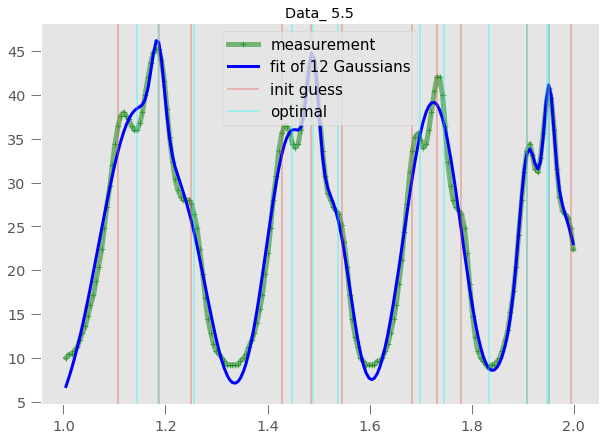

In [16]:
o = do_multiple_fit(data55, guesses=None, dx=0.08, name='5.5', Npeaks=12, llim=1.0, ulim=2, show_indiv=False)

# Performance on a different dataset

In [17]:
testdata = np.loadtxt('./data/T=165-U_2=1.0.txt',encoding='utf-8-sig')

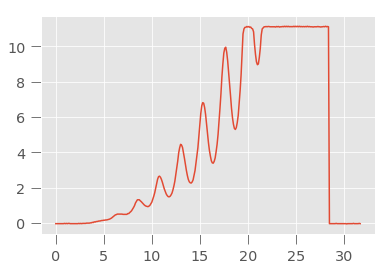

In [18]:
plt.plot(testdata[:,0],testdata[:,1]);

Power_divergenceResult(statistic=397.30692582484136, pvalue=7.762905618209661e-14)


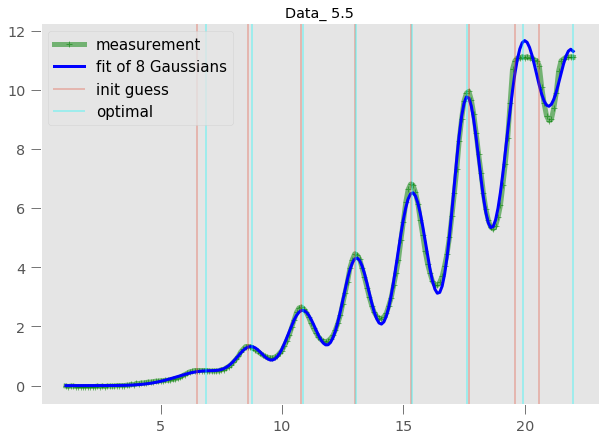

In [19]:
o = do_multiple_fit(testdata, guesses=None, dx=2, name='5.5', Npeaks=8, llim=1.0, ulim=22, show_indiv=False)

Power_divergenceResult(statistic=1.1353076418313837, pvalue=1.0)


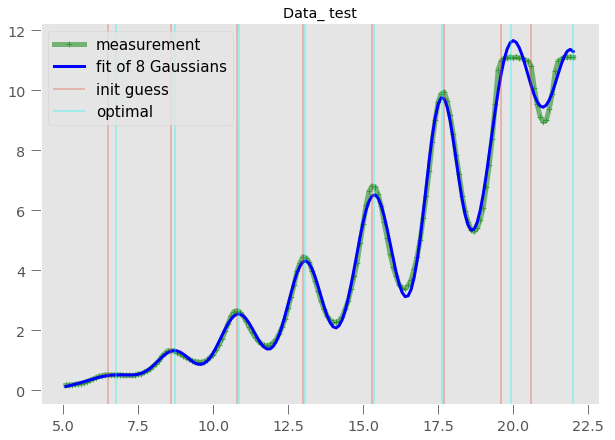

Power_divergenceResult(statistic=4.6086439079474895, pvalue=1.0)


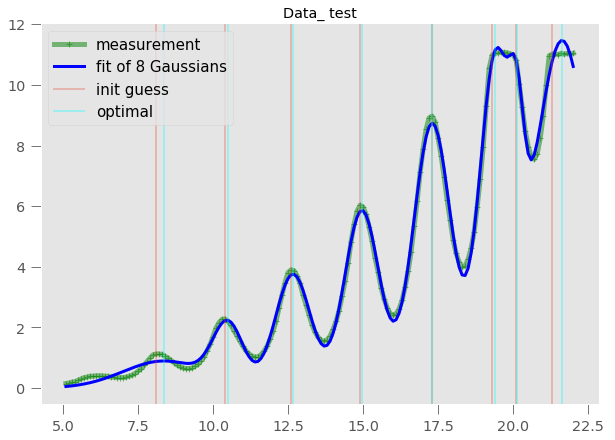

Power_divergenceResult(statistic=2.9788029998233663, pvalue=1.0)


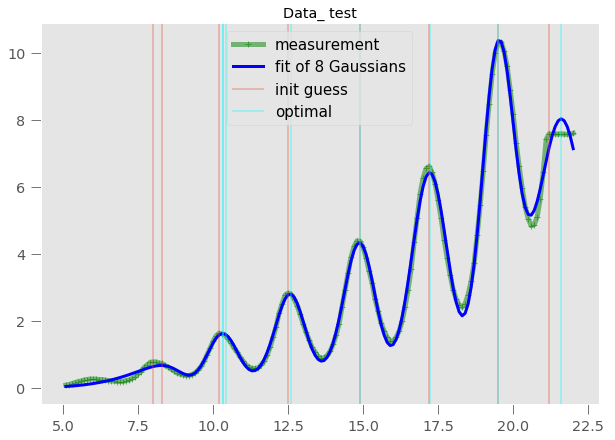

Power_divergenceResult(statistic=35.64848486019231, pvalue=1.0)


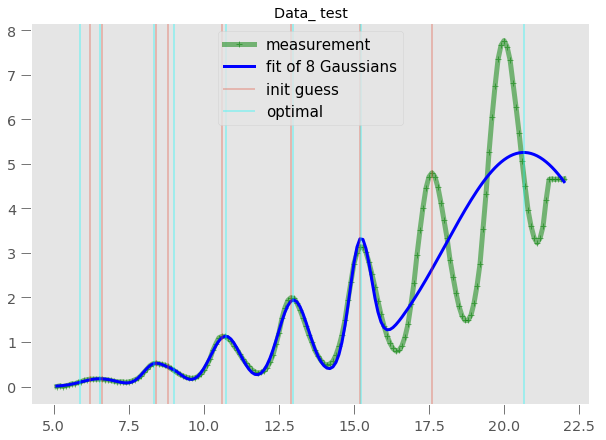

Power_divergenceResult(statistic=28.229064722757435, pvalue=1.0)


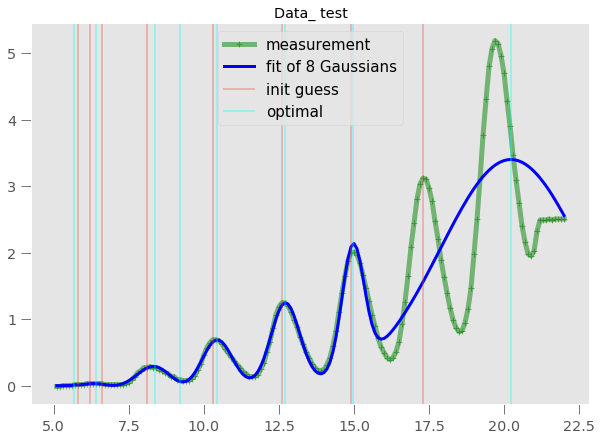

Power_divergenceResult(statistic=215032516.83436385, pvalue=0.0)


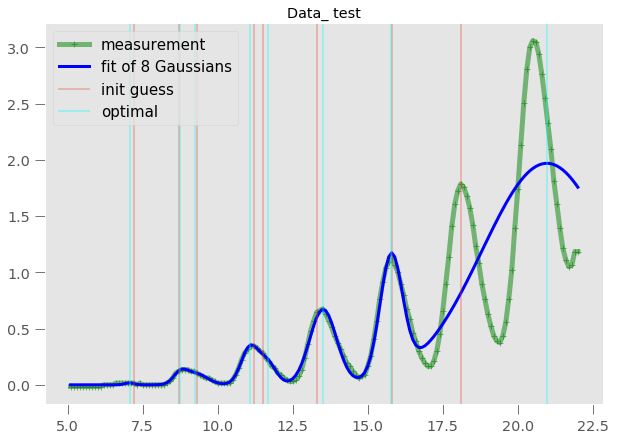

In [20]:
for data in glob('./data/T*'):
    testdata = np.loadtxt(data,encoding='utf-8-sig')
    o = do_multiple_fit(testdata, guesses=None, dx=2, name='test', Npeaks=8, llim=5, ulim=22, show_indiv=False)